In [ ]:
!pip install sdmetrics

## SDMetrics Quality Report Visualizations

The SDMetrics library offers a Quality Report to evaluate synthetic data against real data. The report includes several visualizations that help assess how well the synthetic data captures the statistical properties of the real data. Two key visualizations are **Column Shapes** and **Column Pair Trends**.

### Column Shapes

This visualization evaluates the distribution of individual columns, often using metrics like the KSComplement for continuous data or the TVComplement for categorical data.

#### What to Look For:

- **Distribution Similarity**: The synthetic data's distribution should closely align with that of the real data.
- **Score**: A score near 1 suggests a high similarity between the synthetic and real data distributions.

### Column Pair Trends

This visualization assesses the relationships between column pairs, examining how well the synthetic data maintains the joint distribution between them.

#### What to Look For:

- **Correlation Consistency**: Correlations present in the real data should be reflected in the synthetic data.
- **Score**: A score approaching 1 indicates that the relationships between columns are well preserved in the synthetic data.

Overall, a higher score in the Quality Report signifies that the synthetic data retains the real data's statistical properties effectively, which is essential for the reliability of synthetic data in analytical applications.


In [53]:
import pandas as pd
from sdmetrics.reports.single_table import QualityReport
import plotly.io as pio
from IPython.display import HTML

pio.renderers.default = 'notebook_connected'



def generate_metadata(df, primary_key: str=None):
    """
    Generate metadata required for the quality report

    Parameters:
    df (pd.DataFrame): DataFrame for which to generate metadata.

    Returns:
    dict: Metadata dictionary for SDMetrics.
    """
    
    metadata = {'primary_key': primary_key, 'columns': {}}
    
    dtype_mappings = {
        'int64': ('numerical', 'int'),
        'float64': ('numerical', 'float'),
        'bool': ('boolean', None),
        'datetime64[ns]': ('datetime', None),
        'category': ('categorical', None)
    }
    
    for column, dtype in df.dtypes.items():
        dtype_key = str(dtype)
        sdtype, subtype = dtype_mappings.get(dtype_key, ('categorical', None))
        column_metadata = {'sdtype': sdtype}
        if subtype:
            column_metadata['type'] = subtype
        metadata['columns'][column] = column_metadata
    
    return metadata

def evaluate_data_quality(real_data, transformed_data, metadata):
    """
    Evaluate the quality of transformed data in comparison to real data.

    Parameters:
    real_data (pd.DataFrame): The real data
    transformed_data (pd.DataFrame): The 'transformed data
    metadata (dict): The metadata dictionary for the data.

    Returns:
    QualityReport: The generated quality report object.
    """
    report = QualityReport()
    report.generate(real_data=real_data, synthetic_data=transformed_data, metadata=metadata, verbose=True)
    return report

def print_report_details(report):
    """
    Print the details of the quality report.

    Parameters:
    report (QualityReport): The quality report object to print details from.
    """
    print(f"Overall Quality Score: {report.get_score()}")
    print("Properties Scores:")
    print(report.get_properties())
    print("Column Shapes Details:")
    print(report.get_details(property_name='Column Shapes'))


def evaluate_synthetic_dataset(df, df_transformed):
    real_data = pd.DataFrame(df)
    transformed_data = pd.DataFrame(df_transformed)

    # Generate metadata
    metadata = generate_metadata(real_data)

    # Evaluate data quality
    quality_report = evaluate_data_quality(real_data, transformed_data, metadata)

    # Report details
    print_report_details(quality_report)

    # Visualize the report 
    fig_shapes = quality_report.get_visualization(property_name='Column Shapes')
    fig_pairs = quality_report.get_visualization(property_name='Column Pair Trends')
    
    
    # Save the report
    quality_report.save(filepath='quality_report.pkl')
    
    return fig_shapes , fig_pairs

def compare_query_results(real_result, synthetic_result):
    """
    Compare the results of queries executed on real and synthetic datasets.

    Parameters:
    real_result: The result of the query executed on the real dataset.
    synthetic_result: The result of the query executed on the synthetic dataset.

    Returns:
    dict: A dictionary containing the results and the absolute error.
    """
    # Calculate the absolute error between the real and synthetic query results
    error = abs(real_result - synthetic_result)

    # Return the results and the error
    return {
        'real_result': real_result,
        'synthetic_result': synthetic_result,
        'absolute_error': error
    }


# example dataframe for real data
real_data = pd.DataFrame({
    'ID': [1, 2, 3, 4, 5],
    'Age': [25, 35, 45, 20, 30],
    'Gender': pd.Categorical(['Male', 'Female', 'Female', 'Male', 'Female']),
    'Income': [50000, 60000, 55000, 45000, 65000],
    'Subscriber': [True, False, True, True, False]
})

# Synthetic dataframe
transformed_data = pd.DataFrame({
    'ID': [1, 2, 3, 4, 5],
    'Age': [26, 34, 44, 21, 31],
    'Gender': pd.Categorical(['Male', 'Female', 'Female', 'Male', 'Female']),
    'Income': [51000, 61000, 54000, 44000, 66000],
    'Subscriber': [True, False, False, True, True]
})

# Run the evaluation
fig_shapes , fig_pairs = evaluate_synthetic_dataset(real_data, transformed_data)

# Let's also compare a simple mean query result between the real and synthetic data
real_query_result = real_data['Income'].mean()
synthetic_query_result = transformed_data['Income'].mean()

comparison_results = compare_query_results(real_query_result, synthetic_query_result)

print('########################## Comparison Results ##########################')
print(comparison_results)


Generating report ...
(1/2) Evaluating Column Shapes: : 100%|██████████| 5/5 [00:00<00:00, 630.65it/s]

/opt/conda/lib/python3.10/site-packages/sdmetrics/single_column/statistical/kscomplement.py:59: RuntimeWarning:

ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.




(2/2) Evaluating Column Pair Trends: : 100%|██████████| 10/10 [00:00<00:00, 54.01it/s]

Overall Quality Score: 84.67%

Properties:
- Column Shapes: 92.0%
- Column Pair Trends: 77.35%
Overall Quality Score: 0.8467432715815963
Properties Scores:
             Property     Score
0       Column Shapes  0.920000
1  Column Pair Trends  0.773487
Column Shapes Details:
       Column        Metric  Score
0          ID  KSComplement    1.0
1         Age  KSComplement    0.8
2      Gender  TVComplement    1.0
3      Income  KSComplement    0.8
4  Subscriber  TVComplement    1.0
########################## Comparison Results ##########################
{'real_result': 55000.0, 'synthetic_result': 55200.0, 'absolute_error': 200.0}


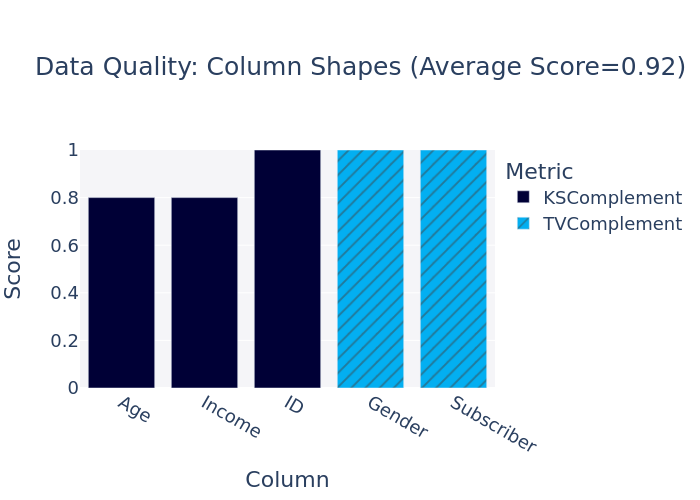

In [55]:
#Interactive
# HTML(fig_shapes.to_html())

#Static
fig_shapes.show(renderer='png')

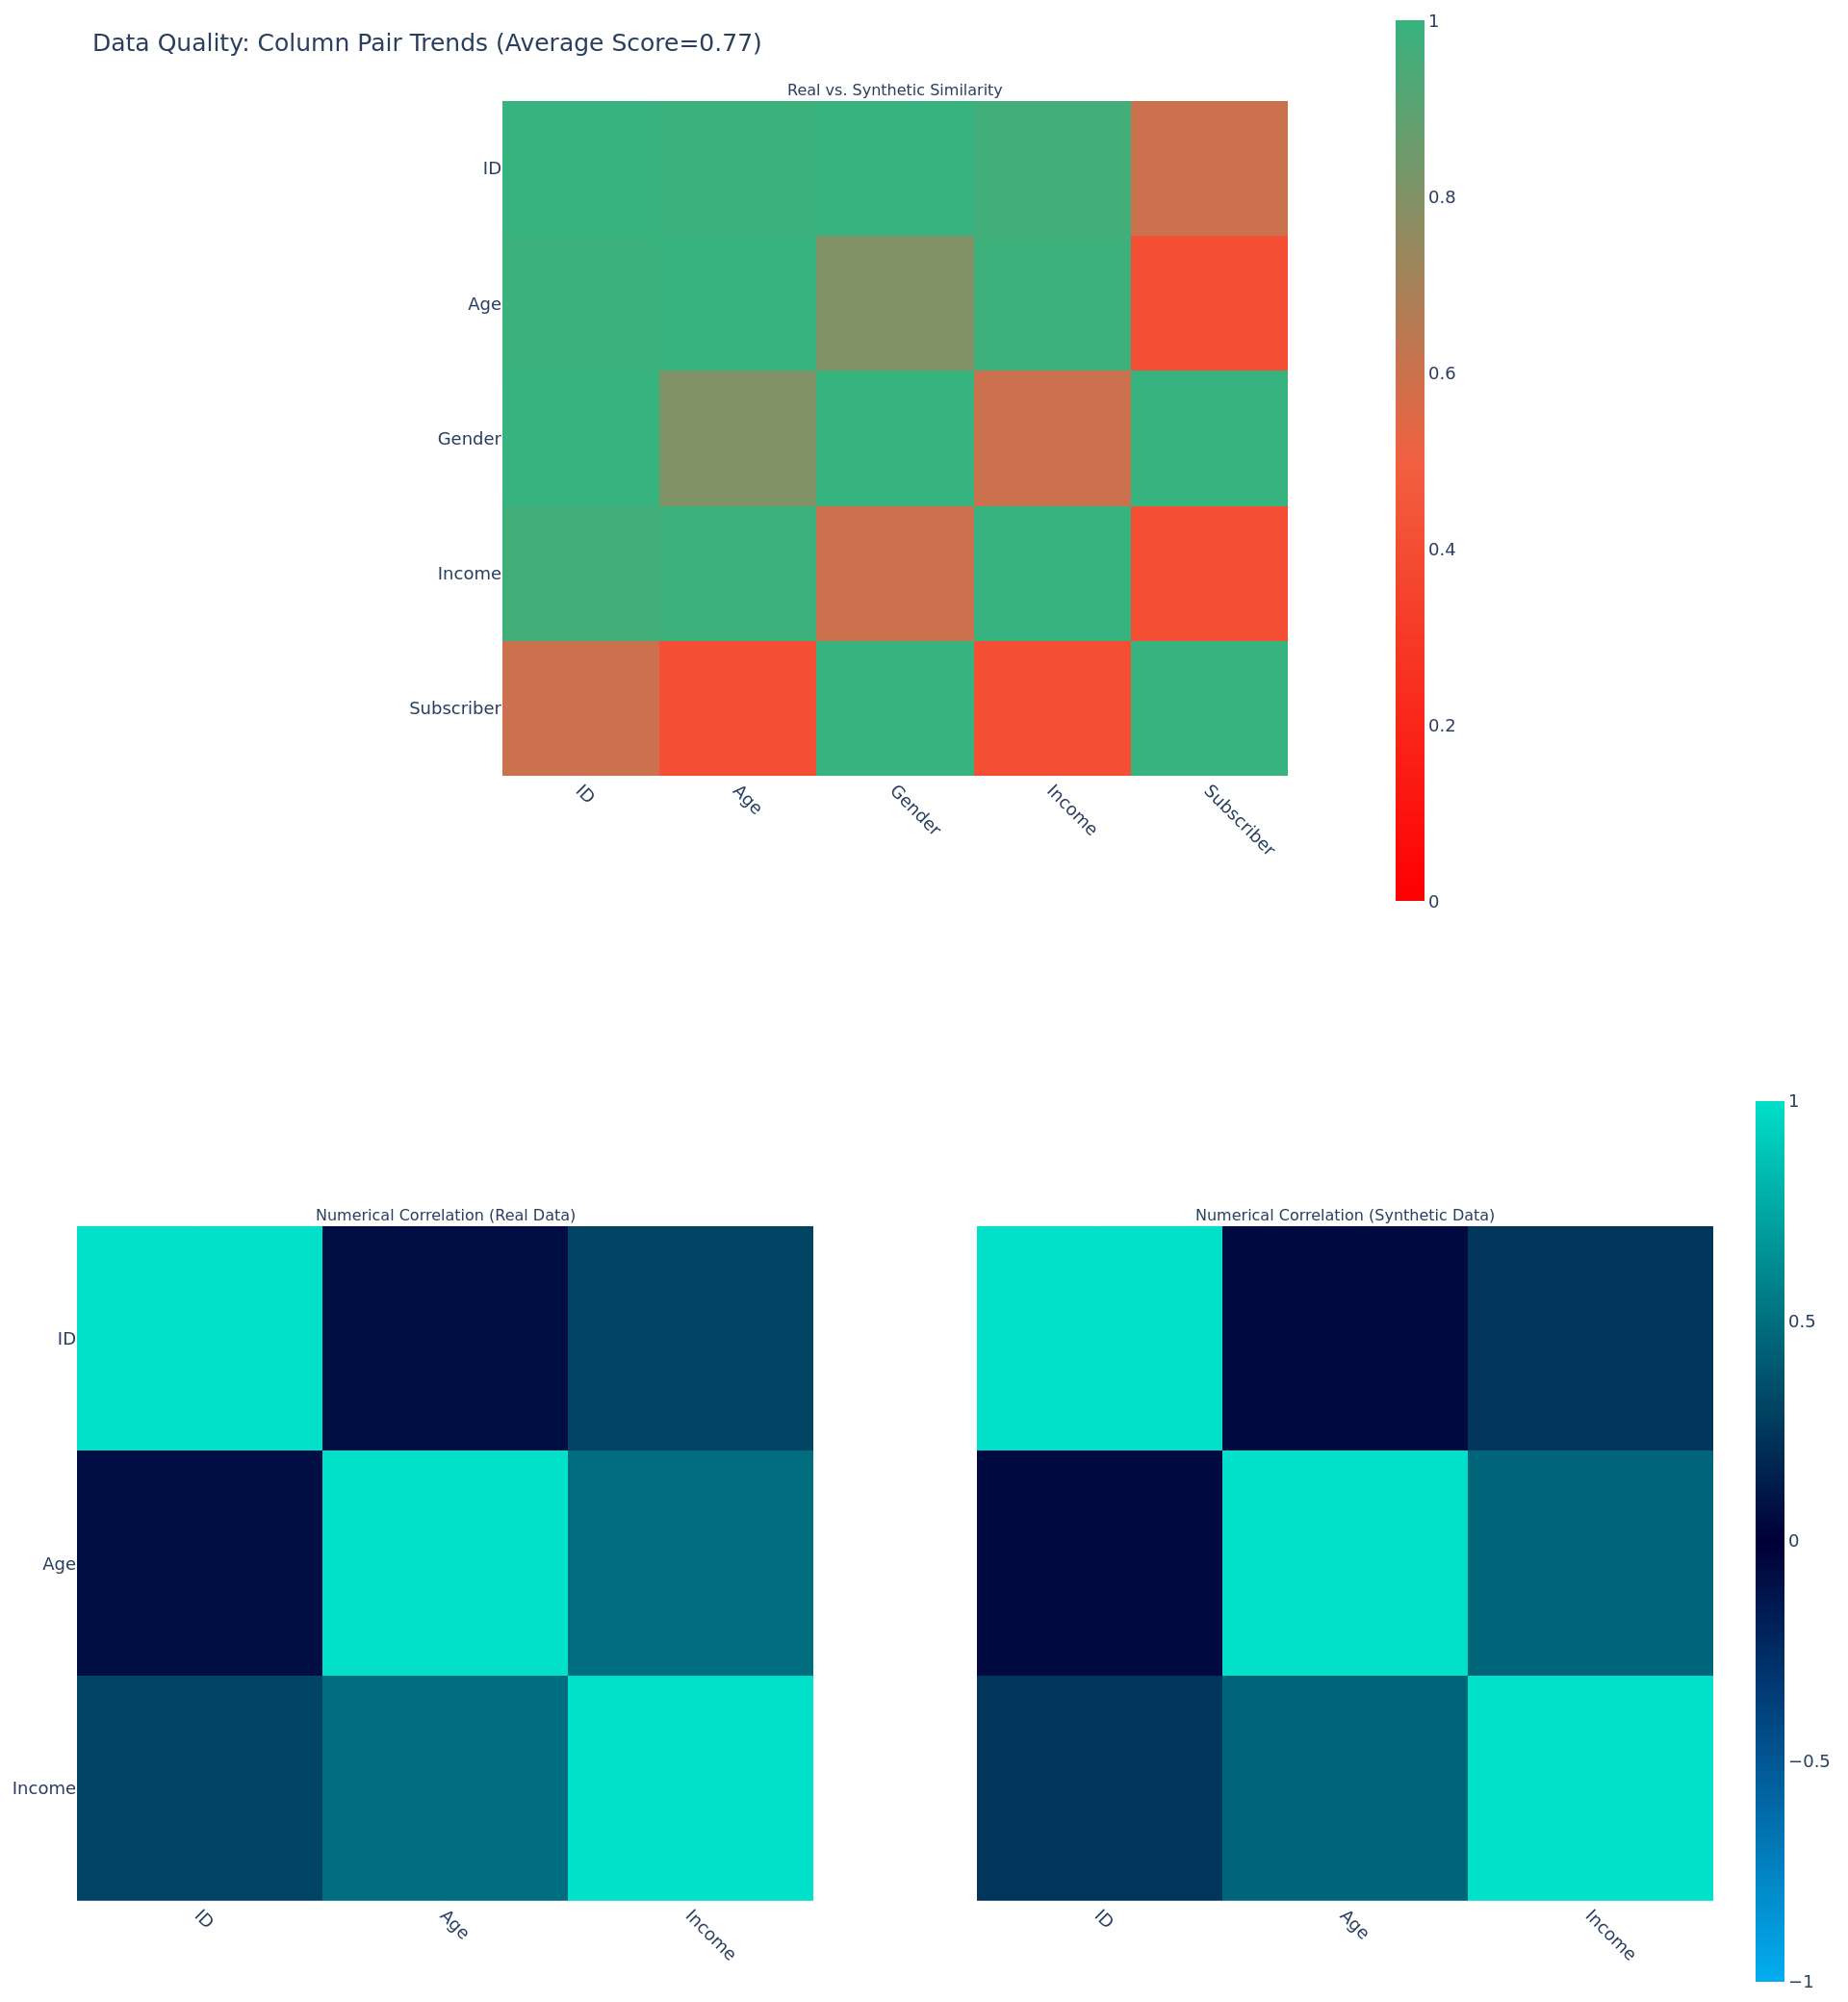

In [56]:
#fix scale
fig_pairs.update_layout(
                        width=1920,
                        height=2080)

#Interactive
HTML(fig_pairs.to_html())


#Static
fig_pairs.show(renderer='png')

In [18]:

pio.renderers
# HTML(fig.to_html())

Renderers configuration
-----------------------
    Default renderer: 'notebook_connected'
    Available renderers:
        ['plotly_mimetype', 'jupyterlab', 'nteract', 'vscode',
         'notebook', 'notebook_connected', 'kaggle', 'azure', 'colab',
         'cocalc', 'databricks', 'json', 'png', 'jpeg', 'jpg', 'svg',
         'pdf', 'browser', 'firefox', 'chrome', 'chromium', 'iframe',
         'iframe_connected', 'sphinx_gallery', 'sphinx_gallery_png']

In [ ]:
#example with transformed dataset in local_dp
real_data = pd.DataFrame(df)  
transformed_data = pd.DataFrame(df_transformed) 


evaluate_synthetic_dataset(df, df_transformed)



# Load the report
# loaded_report = QualityReport.load('quality_report.pkl')

# document the results we are looking at.